# **My 2024 Claude heatmap of usage**

## Data

Go to **Settings** > **Account** > **Data** > **Export Data**. Check you email and download zip file. We'll get the `conversations.json`.

Load data:

In [1]:
import json

with open('conversations.json', 'r') as f:
    claude_convs = json.load(f)

This function is about converting UTC timezone to our local timezone:

In [4]:
from datetime import datetime, timezone
import pytz

def convert_claude_timestamps(convs, local_tz, claude=True):
    convo_times = []
    for conv in convs:
        # Parse ISO format string to datetime
        utc_datetime = datetime.strptime(conv['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")

        # Add UTC timezone info
        utc_datetime = utc_datetime.replace(tzinfo=timezone.utc)

        # Convert UTC to local timezone
        local_datetime = utc_datetime.astimezone(pytz.timezone(local_tz))
        convo_times.append(local_datetime)

    return convo_times

In [5]:
local_tz = 'Asia/Ho_Chi_Minh'

claude_convo_times = convert_claude_timestamps(claude_convs, local_tz)


## Plotting

In [16]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from datetime import timedelta


def plot_claude_convs(convs_times, year: int):
    
    # converting time to date and filter for given year
    claude_dates = [convo.date() for convo in convs_times if convo.year == year]
    
    # counting
    claude_counts = Counter(claude_dates)
    
    # create a full year date range
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()
    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]
        
    # prepare data
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = claude_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1
    
    # plot the heatmap
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    max_count_date = max(claude_counts, key=claude_counts.get)
    max_count = claude_counts[max_count_date]
    p90_count = np.percentile(list(claude_counts.values()), 90)
    for week, day_of_week, count in data:
        color = plt.cm.Oranges((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    # Replace week numbers with month names below the heatmap
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                    if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    # Adjustments for readability
    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(
        f'{year} Claude 3.5 Sonnet Conversation Heatmap (total={sum(claude_counts.values())}).\nMost active day: {max_count_date} with {max_count} convos.',
        fontsize=16
    )
    plt.xticks([])
    plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.gca().invert_yaxis()
    plt.show()

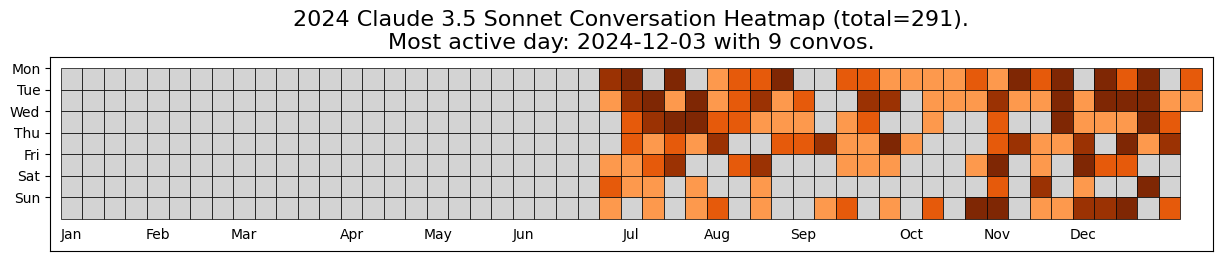

In [14]:
plot_claude_convs(claude_convo_times, 2024)

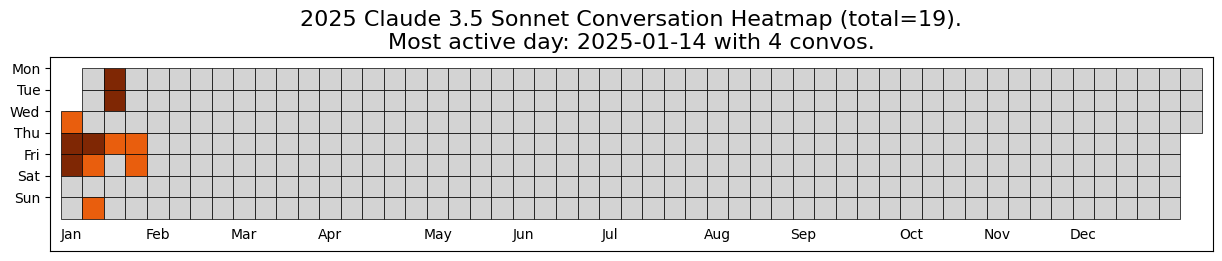

In [15]:
plot_claude_convs(claude_convo_times, 2025)